# Seen vs. unseen based on Text4Vis

#### load data

In [1]:
# load similarites from output/ folder

import numpy as np

folder = 'output/'

sim_train = np.load(folder + '/sampled_training_similarity_150.npy')
sim_val = np.load(folder + '/sampled_validation_similarity_150.npy')

label_train = np.load(folder + '/sampled_training_label_150.npy')
label_val = np.load(folder + '/sampled_validation_label_150.npy')

print('sim_train.shape', sim_train.shape)
print('sim_val.shape', sim_val.shape)
print('label_train.shape', label_train.shape)
print('label_val.shape', label_val.shape)

sim_train.shape (600, 150)
sim_val.shape (602, 150)
label_train.shape (600,)
label_val.shape (602,)


In [2]:
# check if the similarity of a row sums to 1
temp = sim_train.sum(axis=1)
temp = sim_val.sum(axis=1)
print('temp.shape', temp.shape)
print('temp.min()', temp.min())
print('temp.max()', temp.max())

temp.shape (602,)
temp.min() 0.99999964
temp.max() 1.0000004


### Threshold max of softmax probability 

#### train - get max of softmax

In [3]:
# get the max of the predicted softmax probabilities for each sample
train_max_softmax = np.max(sim_train, axis=1)
print('train_max_softmax.shape', train_max_softmax.shape)
print('train_max_softmax.min()', train_max_softmax.min())
print('train_max_softmax.max()', train_max_softmax.max())

train_max_softmax.shape (600,)
train_max_softmax.min() 0.118559256
train_max_softmax.max() 0.99999964


#### train - ROC curve

In [4]:
# convert the class labels to binary labels (1: seen, 0: unseen)

label_train_binary = []
for i in range(label_train.shape[0]):
    if label_train[i] < 150:
        label_train_binary.append(1) # seen class
    else:
        label_train_binary.append(0) # unseen class

label_train_binary = np.array(label_train_binary)
print('label_train_binary.shape', label_train_binary.shape)

label_train_binary.shape (600,)


roc_auc = 0.7764148148148149
Threshold corresponding to top-left corner: 0.8516716


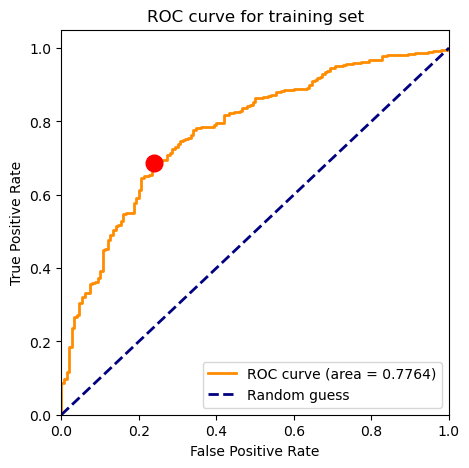

In [5]:
#  calculate the ROC curve 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(label_train_binary, train_max_softmax)
roc_auc = auc(fpr, tpr)
print('roc_auc =', roc_auc)

# plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC curve for training set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")


# Find threshold corresponding to top-left corner
top_left_idx = np.argmax(tpr + (1 - fpr))
threshold_top_left = thresholds[top_left_idx]
print('Threshold corresponding to top-left corner:', threshold_top_left)

# plot the threshold on the ROC curve
plt.plot(fpr[top_left_idx], tpr[top_left_idx], 'ro', markersize=12)
plt.show()

#### val - apply the selected threshold

In [6]:
# get the max of the predicted softmax probabilities for each sample
val_max_softmax = np.max(sim_val, axis=1)
print('val_max_softmax.shape', val_max_softmax.shape)
print('val_max_softmax.min()', val_max_softmax.min())
print('val_max_softmax.max()', val_max_softmax.max())

val_max_softmax.shape (602,)
val_max_softmax.min() 0.14946045
val_max_softmax.max() 1.0


In [7]:
# convert the class labels to binary labels (1: seen, 0: unseen)

label_val_binary = []
for i in range(label_val.shape[0]):
    if label_val[i] < 150:
        label_val_binary.append(1) # seen class
    else:
        label_val_binary.append(0) # unseen class

label_val_binary = np.array(label_val_binary)
print('label_val_binary.shape', label_val_binary.shape)

label_val_binary.shape (602,)


In [8]:
# use the threshold corresponding to top-left corner to get the predicted binary labels

val_pred = []
# threshold_top_left = 0.5
for i in range(val_max_softmax.shape[0]):
    if val_max_softmax[i] > threshold_top_left:
        val_pred.append(1) # seen class
    else:
        val_pred.append(0) # unseen class

val_pred = np.array(val_pred)
print('val_pred.shape', val_pred.shape)

# calculate the accuracy, confusion matrix
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(label_val_binary, val_pred)
f1 = f1_score(label_val_binary, val_pred)
print('threshold_top_left =', threshold_top_left)
print('accuracy =', accuracy)
print('f1 =', f1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_val_binary, val_pred)
print('confusion_matrix =')
print(cm)
print('TP =', cm[1, 1])
print('FP =', cm[0, 1])
print('FN =', cm[1, 0])
print('TN =', cm[0, 0])

val_pred.shape (602,)
threshold_top_left = 0.8516716
accuracy = 0.6810631229235881
f1 = 0.7611940298507462
confusion_matrix =
[[104  46]
 [146 306]]
TP = 306
FP = 46
FN = 146
TN = 104


### Threshold total entropy

#### train - calculate entropy from softmax

In [9]:
def calculate_entropy(y_pred_softmax):
    res = 0
    for i in range(y_pred_softmax.shape[0]):
        p = y_pred_softmax[i]
        if p > 1e-15: # avoid log(0) and -inf
            res -= p * np.log2(p)
    return res

# convert the softmax probabilities of each sample to a entropy value
train_entropy = []
for i in range(sim_train.shape[0]):
    train_entropy.append(calculate_entropy(sim_train[i]))
    
train_entropy = np.array(train_entropy)
print('train_entropy.shape', train_entropy.shape)

# check if NaN exists in the entropy values
print('number of NaN:', np.isnan(train_entropy).sum())
print('max entropy:', train_entropy.max())
print('min entropy:', train_entropy.min())
print('avg entropy:', train_entropy.mean())
print('std entropy:', train_entropy.std())

train_entropy.shape (600,)
number of NaN: 0
max entropy: 5.324928488112505
min entropy: 8.373793536102113e-06
avg entropy: 0.9501011604631232
std entropy: 1.154318133661253


#### train - ROC curve

Note that here we use 0 for seen, 1 for unseen, because the higher the entropy, the larger the uncertainty, thus more likely to be a unseen class.

In [10]:
# convert the class labels to binary labels (0: seen, 1: unseen)

label_train_binary = []
for i in range(label_train.shape[0]):
    if label_train[i] < 150:
        label_train_binary.append(0) # seen class
    else:
        label_train_binary.append(1) # unseen class

label_train_binary = np.array(label_train_binary)
print('label_train_binary.shape', label_train_binary.shape)

label_train_binary.shape (600,)


roc_auc = 0.7979259259259258
Threshold corresponding to top-left corner: 1.065886915307913


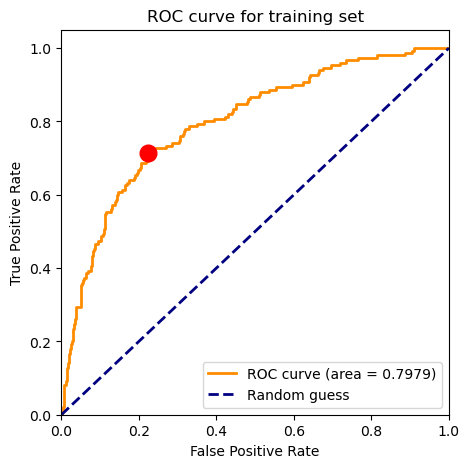

In [11]:
#  calculate the ROC curve 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(label_train_binary, train_entropy)
roc_auc = auc(fpr, tpr)
print('roc_auc =', roc_auc)

# plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC curve for training set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Find threshold corresponding to top-left corner
top_left_idx = np.argmax(tpr + (1 - fpr))
threshold_top_left = thresholds[top_left_idx]
print('Threshold corresponding to top-left corner:', threshold_top_left)

# plot the threshold on the ROC curve
plt.plot(fpr[top_left_idx], tpr[top_left_idx], 'ro', markersize=12)
plt.show()

#### val - apply the selected threshold

In [12]:
# convert the class labels to binary labels (0: seen, 1: unseen)

label_val_binary = []
for i in range(label_val.shape[0]):
    if label_val[i] < 150:
        label_val_binary.append(0) # seen class
    else:
        label_val_binary.append(1) # unseen class

label_val_binary = np.array(label_val_binary)
print('label_val_binary.shape', label_val_binary.shape)

label_val_binary.shape (602,)


In [13]:
# convert the softmax probabilities of each sample to a entropy value
val_entropy = []
for i in range(sim_val.shape[0]):
    val_entropy.append(calculate_entropy(sim_val[i]))
    
val_entropy = np.array(val_entropy)
print('val_entropy.shape', val_entropy.shape)

val_entropy.shape (602,)


In [14]:
# use the threshold corresponding to top-left corner to get the predicted binary labels

val_pred = []
for i in range(val_entropy.shape[0]):
    if val_entropy[i] > threshold_top_left:
        val_pred.append(1) # unseen class
    else:
        val_pred.append(0) # seen class

val_pred = np.array(val_pred)
print('val_pred.shape', val_pred.shape)

# calculate the accuracy, confusion matrix
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(label_val_binary, val_pred)
f1 = f1_score(label_val_binary, val_pred)
print('threshold_top_left =', threshold_top_left)
print('accuracy =', accuracy)
print('f1 =', f1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_val_binary, val_pred)
print('confusion_matrix =')
print(cm)
print('TP =', cm[1, 1])
print('FP =', cm[0, 1])
print('FN =', cm[1, 0])
print('TN =', cm[0, 0])


val_pred.shape (602,)
threshold_top_left = 1.065886915307913
accuracy = 0.739202657807309
f1 = 0.5552407932011332
confusion_matrix =
[[347 105]
 [ 52  98]]
TP = 98
FP = 105
FN = 52
TN = 347
